In [2]:
import glob, os
import pandas as pd
import csv
import dateutil.parser
%matplotlib inline
import matplotlib
import datetime
import calendar
import calendar
import numpy as np
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')


# Preprocessing

##Read files

In [3]:
data_path = "data/"
allFiles = [file for file in glob.glob(data_path+"*.txt")]

In [4]:
df_list=[pd.read_csv(f) for f in allFiles]
df=pd.concat(df_list)

In [5]:
df.rename(columns=lambda x: x.strip(),inplace=True)

In [6]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,00:00:00,REGULAR,5106770,1729635
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,04:00:00,REGULAR,5106810,1729649
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,08:00:00,REGULAR,5106835,1729680
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,12:00:00,REGULAR,5106961,1729784
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,16:00:00,REGULAR,5107250,1729858


## Date parsing

In [7]:
#create 2 new columns in df 'date_time' and 'date_parsed'
df['date_time'] = pd.to_datetime(df.DATE + ' ' + df.TIME)
df['date_parsed'] = pd.to_datetime(df.DATE)

##Sort the entries

In [8]:
df=df.sort(['C/A','UNIT','SCP','STATION','LINENAME','DIVISION','date_time'])

## Get non cummulative count

Since its Already sorted...
lets create a syntetic key by C/A, Unit,SCP,Station

In [9]:
df['key']= tuple(zip(df['C/A'],df['UNIT'],df['SCP'],df['STATION']))

Lets shift the entries,exits and count

In [10]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,date_parsed,key
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,00:00:00,REGULAR,5106770,1729635,2015-04-25 00:00:00,2015-04-25,"(A002, R051, 02-00-00, LEXINGTON AVE)"
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,04:00:00,REGULAR,5106810,1729649,2015-04-25 04:00:00,2015-04-25,"(A002, R051, 02-00-00, LEXINGTON AVE)"
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,08:00:00,REGULAR,5106835,1729680,2015-04-25 08:00:00,2015-04-25,"(A002, R051, 02-00-00, LEXINGTON AVE)"
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,12:00:00,REGULAR,5106961,1729784,2015-04-25 12:00:00,2015-04-25,"(A002, R051, 02-00-00, LEXINGTON AVE)"
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,16:00:00,REGULAR,5107250,1729858,2015-04-25 16:00:00,2015-04-25,"(A002, R051, 02-00-00, LEXINGTON AVE)"


In [11]:
df['shifted_entries']=df['ENTRIES'].shift(periods=1) 
df['shifted_exits']=df['EXITS'].shift(periods=1) 
df['shifted_key']=df['key'].shift(periods=1) 

Subtract from previous if the key is the same

In [12]:
df['ENTRIESn_hourly'] = np.where(df['shifted_key']==df['key'],df['ENTRIES']-df['shifted_entries'],0)
df['EXITSn_hourly'] = np.where(df['shifted_key']==df['key'],df['EXITS']-df['shifted_exits'],0)

The counter might have resetted to 0....lets just skip those rows

In [13]:
min_bad_value=0
max_bad_value=10000

In [14]:
bad_values=df[(df.ENTRIESn_hourly<min_bad_value) | (df.ENTRIESn_hourly>max_bad_value)]
good_values=df[(df.ENTRIESn_hourly>=min_bad_value) & (df.ENTRIESn_hourly<=max_bad_value)]
print ("There are %s bad values and %s good values"%(len(bad_values),len(good_values)))

There are 5419 bad values and 955431 good values


lets save the results and remove miscellaneous columns

In [15]:
df.drop(['shifted_entries','shifted_exits','shifted_key'],inplace=True,axis=1)
df=good_values

## Filter dates for only month of may

In [16]:
#filters date to May 2015
earliest_may_date=datetime.date(2015,5,1)
latest_may_date=datetime.date(2015,5,30)
may_df=df[(df.date_parsed >= earliest_may_date) & (df.date_parsed <= latest_may_date)]
print ("There were %s entries"%(len(df)))
print ("There are %s entries in month of may. So we lost %s entires"%(len(may_df) , len(df)-len(may_df)))

df=may_df

There were 955431 entries
There are 791432 entries in month of may. So we lost 163999 entires


## Total 

In [17]:
df=df.copy()
df['total_traffic'] = df.ENTRIESn_hourly + df.EXITSn_hourly

## Filter weekday and weekend

Moday is 0
Saturday is 5

In [18]:
#filter weekdays only
weekday_date_df=df[df['date_parsed'].dt.weekday < 5]
weekend_date_df=df[df['date_parsed'].dt.weekday >= 5]
#df[df['date_parsed'].dt.weekday < 5].tail(50)

In [19]:
wday_entries_exits=weekday_date_df[['STATION','ENTRIESn_hourly','EXITSn_hourly']].groupby(['STATION']).agg({'EXITSn_hourly':sum,'ENTRIESn_hourly':sum})
wday_entries_exits=wday_entries_exits.reset_index()

wday_entries_exits=wday_entries_exits.sort('EXITSn_hourly',ascending=False)
wday_entries_exits.rename(columns={'ENTRIESn_hourly':'entries', 'EXITSn_hourly':'exits'}, inplace=True)

top_weekday_stations = wday_entries_exits.head(20).reset_index(drop=True)
top_weekday_stations

,STATION,entries,exits
0,34 ST-PENN STA,3745056,3194079
1,42 ST-GRD CNTRL,3275331,3031273
2,34 ST-HERALD SQ,2580463,2317637
3,14 ST-UNION SQ,2308018,2047197
4,86 ST,2429077,1870693
5,42 ST-TIMES SQ,2112047,1864992
6,42 ST-PA BUS TE,1947096,1478327
7,FULTON ST,1675386,1442471
8,47-50 ST-ROCK,1276318,1343816
9,125 ST,1671846,1330222


In [20]:
weekend_entries_exits=weekend_date_df[['STATION','ENTRIESn_hourly','EXITSn_hourly']].groupby(['STATION']).agg({'EXITSn_hourly':sum,'ENTRIESn_hourly':sum})
weekend_entries_exits=weekend_entries_exits.reset_index()

weekend_entries_exits=weekend_entries_exits.sort('EXITSn_hourly',ascending=False)
weekend_entries_exits.rename(columns={'ENTRIESn_hourly':'entries', 'EXITSn_hourly':'exits'}, inplace=True)

weekend_entries_exits.head(20)

top_weekend_stations = weekend_entries_exits.head(20).reset_index(drop=True)
top_weekend_stations

,STATION,entries,exits
0,34 ST-PENN STA,711723,649478
1,14 ST-UNION SQ,591556,541195
2,34 ST-HERALD SQ,559391,499624
3,42 ST-TIMES SQ,549151,490742
4,86 ST,549964,455201
5,42 ST-GRD CNTRL,468558,445326
6,42 ST-PA BUS TE,507479,415759
7,125 ST,417512,372082
8,CANAL ST,388155,317872
9,59 ST-COLUMBUS,384631,294297


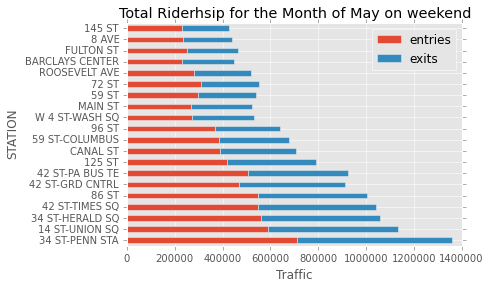

In [30]:
fig=top_weekend_stations.plot('STATION',kind='barh',stacked=True);
plt.title('Total Ridership for the Month of May on weekend')
plt.xlabel('Traffic')

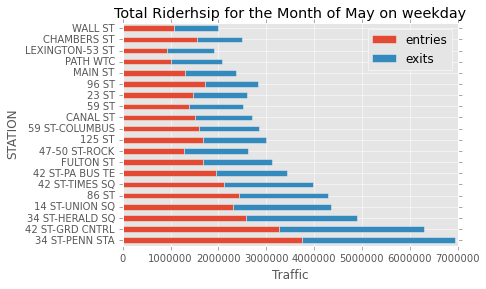

In [31]:
fig=top_weekday_stations.plot('STATION',kind='barh',stacked=True);
plt.title('Total Ridership for the Month of May on weekday')
plt.xlabel('Traffic')

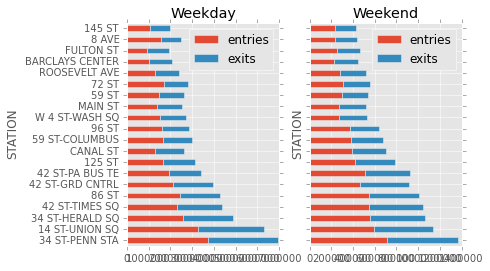

In [32]:
# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

top_weekday_stations.plot('STATION',kind='barh',stacked=True,ax=ax1);
#ax1.set_title('Total Ridership for the Month of May on weekday')
ax1.set_title('Weekday')


top_weekend_stations.plot('STATION',kind='barh',stacked=True,ax=ax2);
ax2.set_title('Weekend')


In [34]:
weekend_entries_exits['type']='weekend'

wday_entries_exits['type']='weekday'
combined=pd.concat([weekend_entries_exits,wday_entries_exits])

In [40]:
l=combined.pivot(index='STATION',columns='type')

l.head()

entries           exits        
type          weekday weekend weekday weekend
STATION                                      
1 AVE          473118   43095  492449   45305
103 ST         593290  124135  462200  104594
103 ST-CORONA  427438  111885  341739  108594
104 ST          50442   10215   33988    8032
110 ST         316543   61727  233282   53065

In [48]:
l.sort(['weekday'],ascending=False).head().plot(kind='barh',stacked=True)
#weekend_entries_exits=weekend_entries_exits.sort('EXITSn_hourly',ascending=False)


KeyError: 'weekday'

In [24]:
#TOTALS FIRST
#get total entries AND exits for the month per station, then get average per day

#<INSERT CODE HERE>

In [25]:
weekend_entries_exits=weekend_date_df[['STATION','ENTRIESn_hourly','EXITSn_hourly']].groupby(['STATION']).agg({'ENTRIESn_hourly':sum,'EXITSn_hourly':sum})
weekend_entries_exits=weekend_entries_exits.reset_index()

weekend_entries_exits=weekend_entries_exits.sort('ENTRIESn_hourly',ascending=False)
weekend_entries_exits.rename(columns={'ENTRIESn_hourly':'entries', 'EXITSn_hourly':'exits'}, inplace=True)

top_stations=weekend_entries_exits.head(10)
top_stations=top_stations.reset_index(drop=True)
top_stations

,STATION,entries,exits
0,34 ST-PENN STA,711723,649478
1,14 ST-UNION SQ,591556,541195
2,34 ST-HERALD SQ,559391,499624
3,86 ST,549964,455201
4,42 ST-TIMES SQ,549151,490742
5,42 ST-PA BUS TE,507479,415759
6,42 ST-GRD CNTRL,468558,445326
7,125 ST,417512,372082
8,CANAL ST,388155,317872
9,59 ST-COLUMBUS,384631,294297


In [26]:
top_station_names=top_stations['STATION'].tolist()

In [27]:
top_station_names

['34 ST-PENN STA',
 '14 ST-UNION SQ',
 '34 ST-HERALD SQ',
 '86 ST',
 '42 ST-TIMES SQ',
 '42 ST-PA BUS TE',
 '42 ST-GRD CNTRL',
 '125 ST',
 'CANAL ST',
 '59 ST-COLUMBUS']

In [28]:
top_stations.index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

In [29]:
type(l)

NameError: name 'l' is not defined

In [ ]:
top_stations['STATION']

In [ ]:
top_stations.index.values

In [ ]:
fig=top_stations.plot(kind='bar',stacked=True);
fig.set_title('Top NY stations for the May on  Weekdays')
plt.xticks(top_stations.index.values,top_stations['STATION'])

# Top in the hours

In [ ]:
top_station_names

In [ ]:
weekday_date_df.head()

In [ ]:
top_stations

In [ ]:
weekday_date_df

In [ ]:
l=weekday_date_df.TIME.unique().tolist()
sorted(l,reverse=True)

In [ ]:
valid_time_ranges=['00:00:00', '04:00:00', '08:00:00', '12:00:00', '16:00:00', '20:00:00']

avg_wkday_entries= weekday_date_df[['STATION','DATE','TIME','ENTRIESn_hourly']].groupby(['STATION','DATE','TIME']).agg({'ENTRIESn_hourly':np.sum})
avg_wkday_entries=avg_wkday_entries.reset_index()

avg_wkday_entries = avg_wkday_entries[avg_wkday_entries['TIME'].isin(valid_time_ranges)]

avg_wkday_entries= avg_wkday_entries[['STATION','TIME','ENTRIESn_hourly']].groupby(['STATION','TIME']).agg({'ENTRIESn_hourly':np.median})
avg_wkday_entries=avg_wkday_entries.reset_index()

avg_wkday_entries = avg_wkday_entries [avg_wkday_entries['STATION'].isin(top_station_names)]

avg_wkday_entries.rename(columns={'ENTRIESn_hourly':'entries'}, inplace=True)

#wday_entries=wday_entries.sort('ENTRIESn_hourly',ascending=False)
#wday_entries.rename(columns={'ENTRIESn_hourly':'entries'}, inplace=True)
avg_wkday_entries_pivot=avg_wkday_entries.pivot(index='TIME', columns='STATION', values='entries')
avg_wkday_entries_pivot.head()



In [ ]:
avg_wkday_entries_pivot.plot()

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Entries')
plt.title('Median Station traffic over hours')

In [ ]:
#TOTALS FIRST
#plot bar graph of average count per day for May 2015, display top 10(?) busiest stations

#<INSERT CODE HERE>

In [ ]:
#BREAKDOWN BY TIME FRAME
#get total entries AND exits for the month per station grouped by timeframes "8am to 12nn", "12nn to 4pm", "4pm to 8pm"
#get average per day

#<INSERT CODE HERE>

In [ ]:
#BREAKDOWN BY TIME FRAME
#plot line graph of average count per day for May 2015, each line in graph representing 1 station

#<INSERT CODE HERE>